### Image style transfer using deep neural networks

The first step is to get only the content(objects and their arrangement) from the content image and only style(colors, textures) from the style image.  
This can be achieved by calculating and minimizing the content and style loss respectively. 

In [1]:
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from torchvision import datasets, transforms, models

In [2]:
import numpy as np
%matplotlib inline

In [3]:
import os

In [4]:
os.listdir('../input')

['lines007', 'mydata', 'vcuvdnixn', 'ctcttv', 'tarzan007']

In [5]:
#root = ''

The VGG19 network is pre-trained with ImageNet dataset. It is used only to extract the content and style features from the image passed in. We will then use the concept of content and style losses to iteratively update the output image until we get the desired result. 
VGG19 is split into two portion:
1. vgg19.features - which are all the convolutional and pooling layers. 
2. vgg19.classifier - which are the three fully connected classifier in the end. 

We are extracting features from vgg19, so only the features part is required. 

In [6]:
model = models.vgg19(pretrained=True).features      # Only convolutional and maxpool layers

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:19<00:00, 29.4MB/s]


In [7]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
# We are freezing all vgg parameters since we are only optimising the target image
# Setting requires_grad = False ensures that none of the weights are changed. 
for param in model.parameters():
    param.requires_grad_(False)
    
# Now, the model has become a fixed feature extractor. 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
device

device(type='cuda')

In [11]:
def load_image(img_path, max_size=1200, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)         # unsqueeze adds the extra dimension
    
    return image

In [12]:
# load in content and style image
content = load_image('../input/tarzan007/images_anim.jpg').to(device)

In [13]:
content.shape           # shape index --> -4, -3, -2, -1

torch.Size([1, 3, 500, 508])

In [14]:
content.shape[-2:]           # index from -2 to -1/0

torch.Size([500, 508])

In [15]:
# Resize style to match content, makes computation easier
style = load_image('../input/mydata/images_abstract.jpg', shape=content.shape[-2:]).to(device)

In [16]:
# To display a image which is of type tensor, we first have to convert it to numpy. 
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()             # 4-dimension to 3-dimension
    image = image.transpose(1,2,0)              
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))           # De-normalizing
    #image = image.clip(0, 1)

    return image

#### np.Clip(limit) the values in an array.
Given an interval, values outside the interval are clipped to the interval edges. For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.

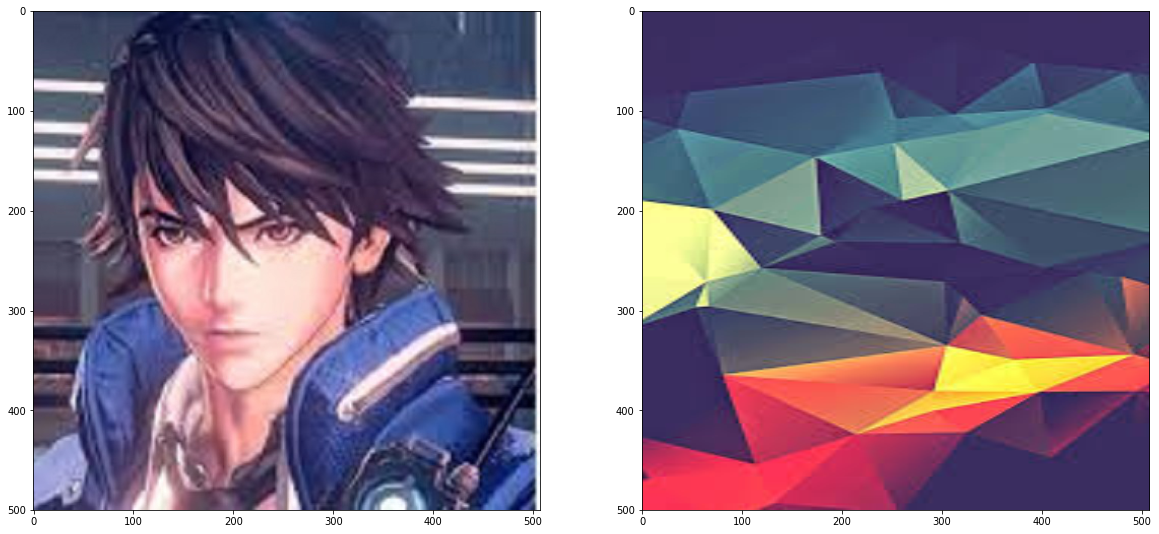

In [17]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style images side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

#### We pass these images through our fixed feature extractor, the vgg model. We'll get the content image from the last convolutional stack and we get the style image by taking feature maps from the first convolutional layer in each of the five convolutional stacks. 

In [18]:
def get_features(image, vgg, layers=None):
    # Forward pass of the imamge through the model. 
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',             # content representation
                  '28': 'conv5_1'}
        
    features = {}        # This is also a dictionary
    x = image
    # model._modules is a dictionary holding each module(layer) in the model  
    # key : layer name, value : layer details
    for name, layer in vgg._modules.items():
        x = layer(x)                             # For the first iteration, the image is passed through layer 1, x then holds 
                                                 # the output of that layer(feature map) which is passed on to the next layer.
        # The image is passed through all the layers, but we extract the feature map only from the desired layers.
        if name in layers:
            features[layers[name]] = x           # layers[0] = conv1_1, features[conv1_1] = That layer's output feature map
            
    return features

In [19]:
#model._modules.items()

In [20]:
#for name, layer in model._modules.items():
#    print(name)
#    print(layer)

#### Gram Matrix
The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
Reshape that tensor so that the spatial dimensions are flattened
Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

In [21]:
def gram_matrix(tensor):
    
    size = tensor.shape
    tensor = tensor.view(size[1],size[2]*size[3])   # Converting each feature map to a vector. Since we also have depth, this 
                                                    # will be depth * (h*w) matrix.
    tensor_transpose = tensor.t()
    
    gram = torch.mm(tensor, tensor_transpose) # This effectively multiplies all the features and gets the correlations
    
    return gram

In [22]:
# We extract the content and style feature only once. These remain the same throughout the process. 
content_features = get_features(content,model)
style_features = get_features(style,model)

In [23]:
for layer in content_features:
    print(content_features[layer])

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 2.2995, 2.3142, 1.5745],
          [0.0000, 0.0000, 0.0000,  ..., 1.9662, 1.9847, 1.4309],
          [0.0000, 0.0000, 0.0000,  ..., 1.9662, 1.9847, 1.4309],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 1.9593, 1.9800, 1.3996],
          [0.0000, 0.0000, 0.0000,  ..., 1.9550, 1.9763, 1.4013],
          [0.0000, 0.0000, 0.0000,  ..., 0.7511, 0.7592, 0.4136]],

         [[1.1646, 0.0000, 0.0000,  ..., 2.5756, 3.1693, 6.2413],
          [2.7305, 0.2603, 0.2603,  ..., 0.0000, 0.7281, 6.0928],
          [2.7604, 0.2754, 0.2754,  ..., 0.0000, 0.7281, 6.0928],
          ...,
          [0.0000, 0.0000, 0.3026,  ..., 0.0000, 0.8108, 6.0639],
          [0.7960, 0.3458, 0.7586,  ..., 0.0000, 0.7927, 6.0336],
          [1.5446, 1.4056, 1.9383,  ..., 0.0000, 0.0000, 0.7967]],

         [[0.0000, 0.0000, 0.0000,  ..., 1.3176, 1.2643, 0.5698],
          [0.0000, 0.0000, 0.0000,  ..., 1.4603, 1.3698, 0.6161],
          [0.0000, 0.0000, 0.0000,  ..., 1

In [24]:
# calculating the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [25]:
# creating a output image which carries the style image. 
# we start the styling process from the content image. Hence, the output will be the content image before the style is applied.
# iterate until the desired style is achieved
output = content.clone().requires_grad_(True).to(device) 

# We can also start with a blank image, but we may get the output image that is too diverted from our content image. 

In [26]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.8,
                 'conv3_1': 0.4,
                 'conv4_1': 0.2,
                 'conv5_1': 0.1}

content_weight = 1e3 # alpha
style_weight = 1e2  # beta

Total loss:  2184.647705078125


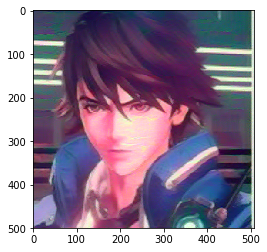

Total loss:  1194.42578125


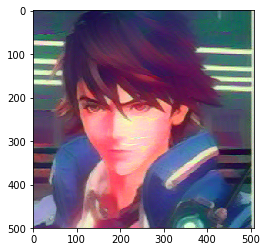

Total loss:  863.7413330078125


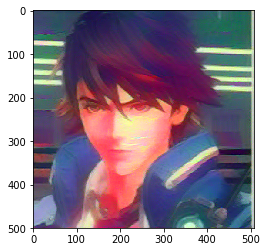

Total loss:  713.2272338867188


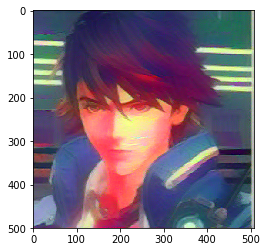

Total loss:  626.8502807617188


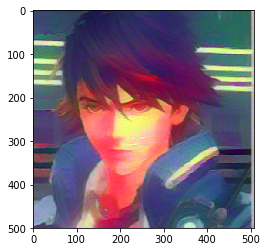

Total loss:  572.117919921875


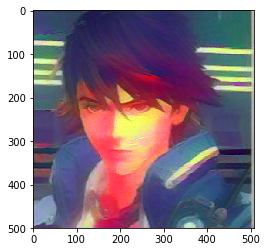

Total loss:  537.08447265625


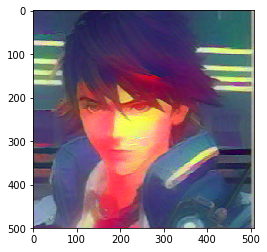

In [27]:
show_every = 400


optimizer = optim.Adam([output], lr=0.003)
epochs = 3000  

for e in range(1, epochs+1):
    
    # get the features from the output image
    output_features = get_features(output, model)         # contains features from both style and content layers  
    
    # the content loss
    content_loss = torch.mean((output_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0         
    
    for layer in style_weights:        # Only style layers
        output_feature = output_features[layer]  # "output" style representation for the layer
        output_gram = gram_matrix(output_feature)      # A particular layer feature. 
        _, d, h, w = output_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((output_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)   # updating the style loss after calculating each layer style loss. 
        # (d*h*w) specifies the total number of values in a particular layer. 
        
    # calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss      # alpha*content_loss + beta*style_loss
    
    # updating the output image itself (not the usual weights that we were updating previously)
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if(e % show_every == 0):
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(output))
        plt.show()

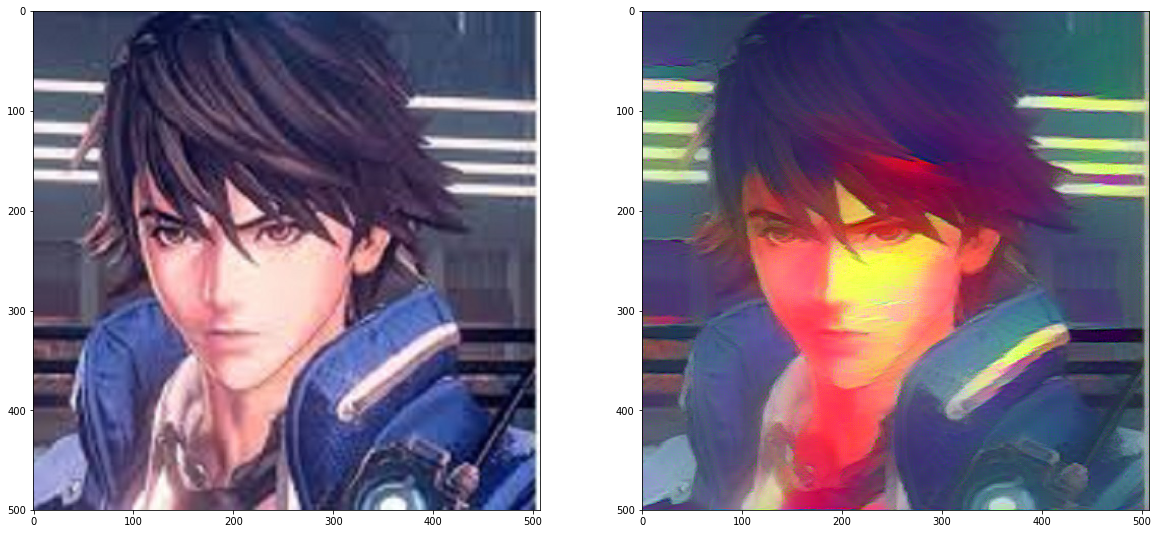

In [28]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(output))

In [29]:
# Saving the output style image
import cv2
cv2.imwrite('../input/Style_transfer_10.jpg',im_convert(output))

True